# Analyzing Urban Areas

This notebook shows how we can perform POI-based analysis for urban areas. Discretization of urban areas allows spatial analysis. For example, a very typical use case is to create heatmaps. You can read any spatial data that you have (e.g., real estate prices, air pollution, etc.) and start to analyze them based on the created tiles. Here we use Open Street Map to show several example use cases.

We create heatmaps of amenities based on different tessellation methods. Moreover, investigate the autocorrelation between polygons by calculating Moran's I. In addition, different types of amenities can be extracted from POI data. For example, we visualize cafes and restaurants.

To run this notebook, in addition to `tesspy`, you need `contextily` for basemap visualization and `esda`, `statsmodels`, and `libpysal` for statistical and spatial analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (8, 8)

import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon, MultiPoint
import contextily as ctx

import esda
import libpysal as lp

import statsmodels.api as sm
from scipy.stats import norm

# Shapely 1.8.1 makes pandas to produce many warnings; this is to get rid of these warnings
import warnings

warnings.simplefilter("ignore")

from time import sleep

In [2]:
from tesspy import Tessellation

## Area

We use **Frankfurt am Main** in Germany as a case study. First, we get the city boundary. Then we generate different tessellations. 

In [3]:
ffm = Tessellation("Frankfurt am Main")
ffm_polygon = ffm.get_polygon()

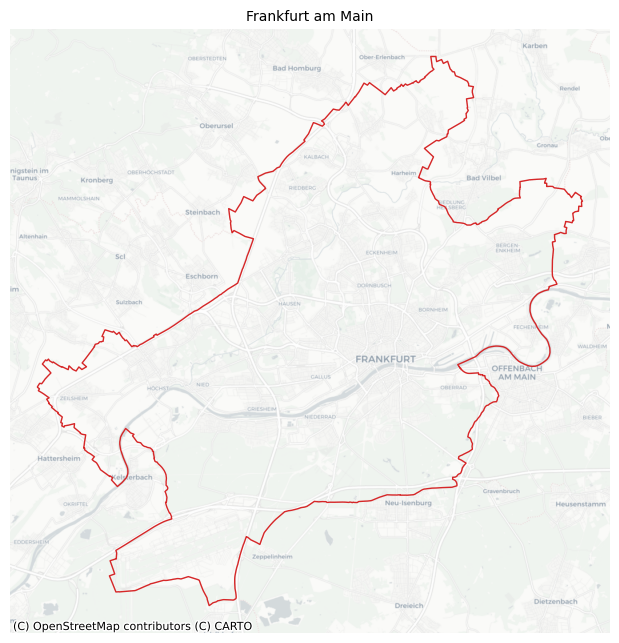

In [4]:
# visualization of area
ax = ffm_polygon.to_crs("EPSG:3857").plot(facecolor="none", edgecolor="tab:red", lw=1)
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title("Frankfurt am Main", fontsize=10)
plt.show()

## Tessellation

In [5]:
# squares
ffm_sqr_16 = ffm.squares(16)
# hexagons
ffm_hex_9 = ffm.hexagons(9)
# adaptive squares
ffm_asq = ffm.adaptive_squares(
    start_resolution=13,
    threshold=500,
    timeout=60,
    poi_categories=["shop", "building", "amenity", "office", "public_transport"],
)
# voronoi Diagrams with K-Means
ffm_voronoi_kmeans = ffm.voronoi(
    poi_categories=["shop", "building", "amenity", "office", "public_transport"],
    n_polygons=1000,
)
# voronoi Diagrams with hdbscan
ffm_voronoi_hdbscan = ffm.voronoi(
    cluster_algo="hdbscan",
    min_cluster_size=10,
    poi_categories=["shop", "building", "amenity", "office", "public_transport"],
)
sleep(120)
# city blocks
ffm_cb = ffm.city_blocks(n_polygons=1000, detail_deg=None)

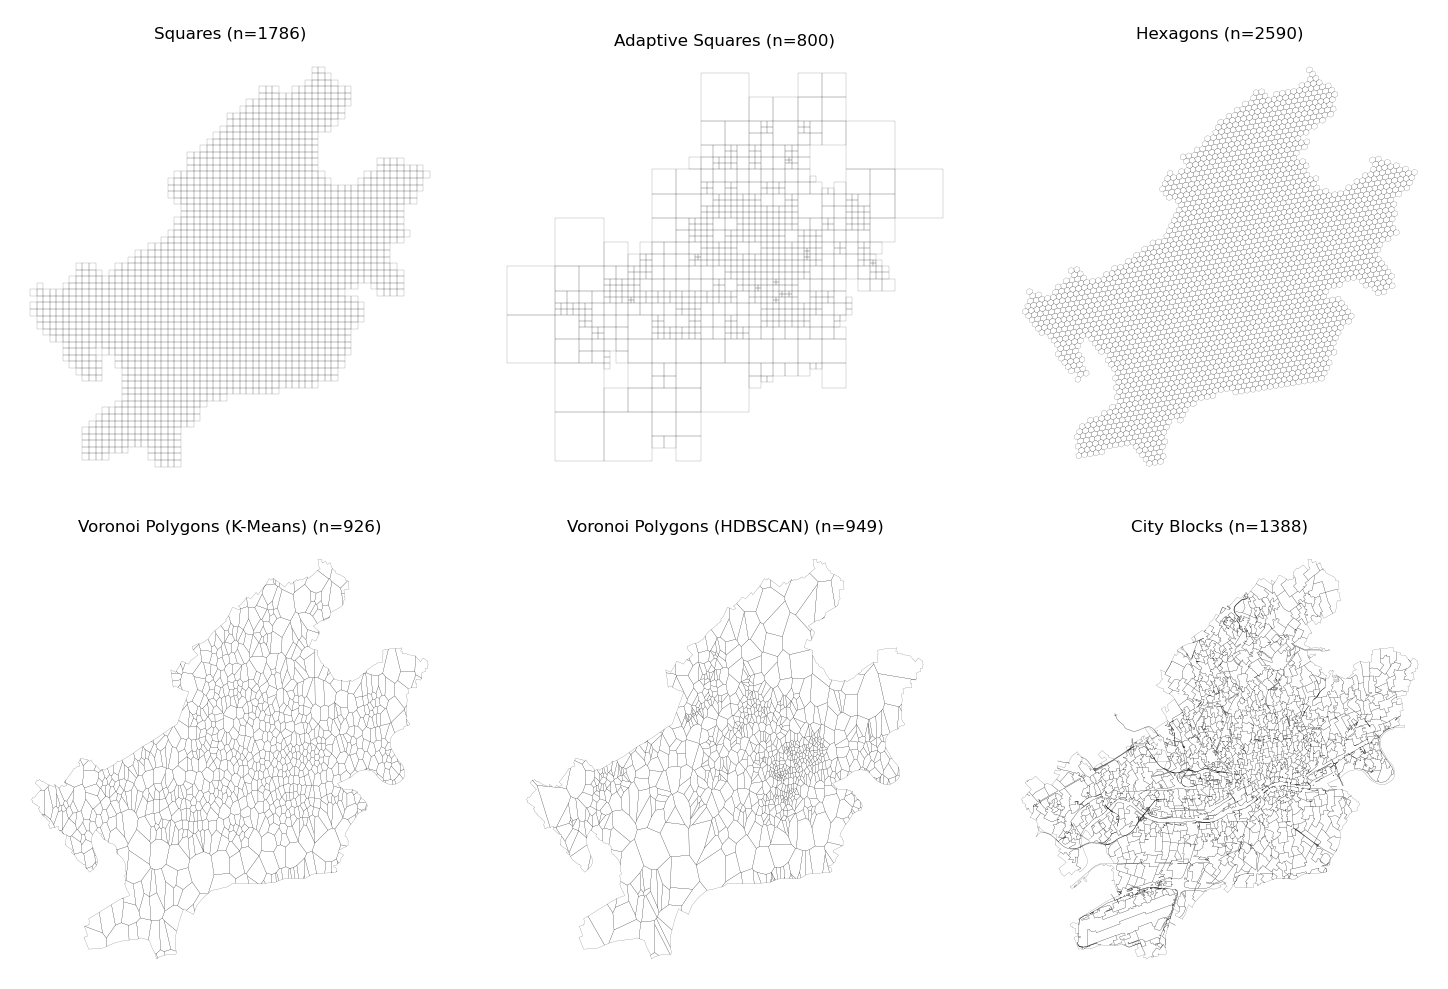

In [6]:
ffm_dfs = [
    ffm_sqr_16,
    ffm_asq,
    ffm_hex_9,
    ffm_voronoi_kmeans,
    ffm_voronoi_hdbscan,
    ffm_cb,
]
titles = [
    "Squares",
    "Adaptive Squares",
    "Hexagons",
    "Voronoi Polygons (K-Means)",
    "Voronoi Polygons (HDBSCAN)",
    "City Blocks",
]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for ax, df, title in zip(axs.flatten(), ffm_dfs, titles):
    ax.set_axis_off()
    df.plot(ax=ax, facecolor="none", edgecolor="k", lw=0.1)
    ax.set_title(f"\n{title} (n={len(df)})")

plt.tight_layout()
plt.show()

We can calculate the areas of polygons (tiles) and see how they differ between different tessellation methods. In square and hexagon methods, the area of polygons is (almost) constant. By Voronoi and city blocks, it varies. We can take a look at their histograms to investigate them.

We convert the CRS to `EPSG:5243` (for Frankfurt). Using this, the coordinates are in meters, and the calculated area is in square meters.

In [7]:
# Calculate Areas

for df in ffm_dfs:
    df["area"] = df.to_crs("EPSG:5243").area

Here are the polygon size for squares:

In [8]:
ffm_sqr_16["area"].describe()

count      1786.000000
mean     153687.014738
std         306.670013
min      152971.129738
25%      153449.226805
50%      153700.251963
75%      153905.940218
max      154341.071288
Name: area, dtype: float64

Here are the polygon size hexagons:

In [9]:
ffm_hex_9["area"].describe()

count     2590.000000
mean     95893.716176
std         80.618428
min      95718.110703
25%      95830.827327
50%      95896.443375
75%      95960.443788
max      96061.804198
Name: area, dtype: float64

For the other Voronoi and city blocks, we create a histogram.

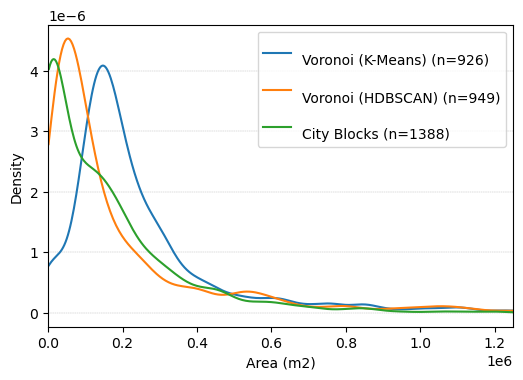

In [10]:
def trunc_dens(x):
    kde = sm.nonparametric.KDEUnivariate(x)
    kde.fit()
    h = kde.bw
    w = 1 / (1 - norm.cdf(0, loc=x, scale=h))
    d = sm.nonparametric.KDEUnivariate(x)
    d = d.fit(bw=h, weights=w / len(x), fft=False)
    d_support = d.support
    d_dens = d.density
    d_dens[d_support < 0] = 0
    return d_support, d_dens


fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for df, title in zip(
    [ffm_voronoi_kmeans, ffm_voronoi_hdbscan, ffm_cb],
    ["Voronoi (K-Means)", "Voronoi (HDBSCAN)", "City Blocks"],
):

    _x, _y = trunc_dens(df["area"])
    ax.plot(_x[_x > 0], _y[-len(_x[_x > 0]) :], label=f"\n{title} (n={df.shape[0]})")
    ax.set_xlabel("Area (m2)")
    ax.set_ylabel("Density")
    ax.grid(axis="y", lw=0.3, ls="--", zorder=0)

plt.legend()
plt.xlim([0, 1.25e6])
plt.show()

## POI data: Amenities

Let's continue by taking a look at the retrieved POI data from OSM:

In [11]:
poi_df = ffm.get_poi_data()
poi_df.head()

type                                           geometry  \
0  way  [{'lat': 50.1074607, 'lon': 8.734269}, {'lat':...   
1  way  [{'lat': 50.1670562, 'lon': 8.6760002}, {'lat'...   
2  way  [{'lat': 50.1488198, 'lon': 8.6928804}, {'lat'...   
3  way  [{'lat': 50.1446936, 'lon': 8.6511394}, {'lat'...   
4  way  [{'lat': 50.0518233, 'lon': 8.5654572}, {'lat'...   

                                                tags  center_latitude  \
0  {'access': 'customers', 'amenity': 'parking', ...        50.107625   
1  {'amenity': 'school', 'contact:email': 'schull...        50.167461   
2  {'amenity': 'prison', 'barrier': 'fence', 'nam...        50.149950   
3  {'addr:city': 'Frankfurt am Main', 'addr:house...        50.145195   
4  {'addr:city': 'Frankfurt am Main', 'addr:postc...        50.052712   

   center_longitude  amenity  building  office  public_transport   shop  
0          8.734458     True     False   False             False  False  
1          8.675039     True     False   False             False  False  
2          8.695300     True     False   False             False  False  
3          8.650782     True     False   False             False  False  
4          8.568809    False      True   False             False  False

This dataframe contains geometry and other tags of the selected POI categories. We can take a look at the total number of each POI category in Frankfurt:

In [12]:
poi_df.iloc[:, -5:].sum()

amenity              19799
building            144471
office                 689
public_transport      5159
shop                  4357
dtype: int64

Let's visualize amenities on the map:

In [13]:
poi_geodata = gpd.GeoDataFrame(
    data=poi_df.drop(columns=["geometry"]),
    geometry=poi_df[["center_longitude", "center_latitude"]]
    .apply(Point, axis=1)
    .values,
    crs="EPSG:4326",
)

amenity_data = poi_geodata[poi_geodata["amenity"]].copy()

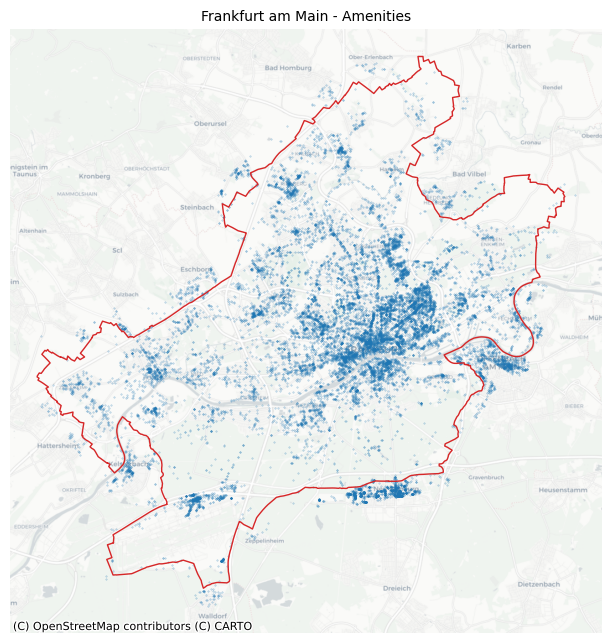

In [14]:
# visualization of area
ax = amenity_data.to_crs("EPSG:3857").plot(color="tab:blue", markersize=0.1, alpha=0.5)
ffm_polygon.to_crs("EPSG:3857").plot(ax=ax, facecolor="none", edgecolor="tab:red", lw=1)

ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title("Frankfurt am Main - Amenities", fontsize=10)
plt.show()

Using the `tags` in the data, we can analyze the amenities further. For example, the types of amenities can be extracted. Different heatmaps for different amenity types can be provided.

In [15]:
amenity_data["amenity_type"] = amenity_data["tags"].apply(lambda x: x["amenity"])

In [16]:
amenity_data["amenity_type"].value_counts().head(20)

bicycle_parking     3430
bench               2225
parking             2223
restaurant          1392
parking_space       1272
waste_basket         847
recycling            797
vending_machine      696
kindergarten         580
cafe                 508
post_box             492
fast_food            473
parking_entrance     383
place_of_worship     318
bar                  246
school               242
shelter              214
pub                  201
telephone            189
pharmacy             177
Name: amenity_type, dtype: int64

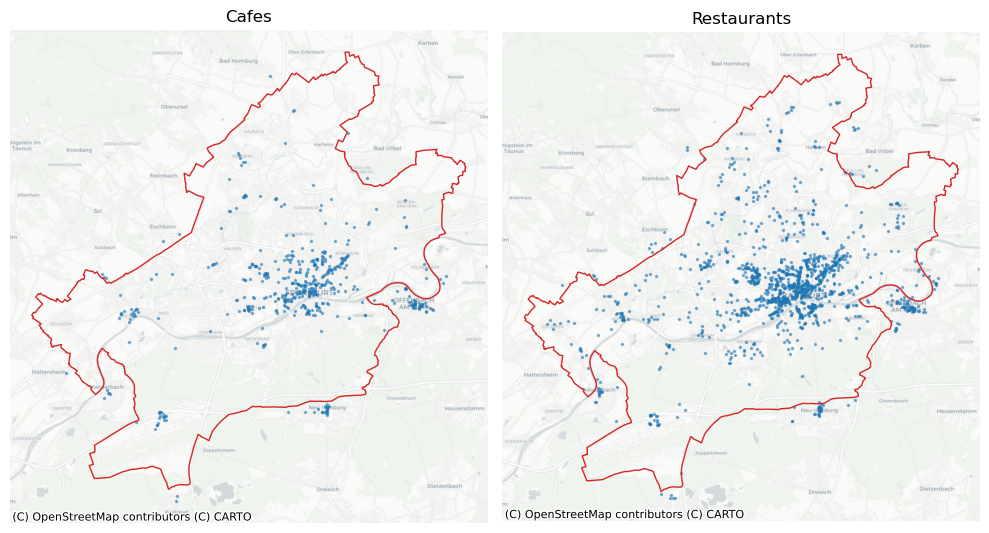

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))
amenity_data[amenity_data["amenity_type"] == "cafe"].to_crs("EPSG:3857").plot(
    ax=axs[0], color="tab:blue", markersize=2, alpha=0.5
)
amenity_data[amenity_data["amenity_type"] == "restaurant"].to_crs("EPSG:3857").plot(
    ax=axs[1], color="tab:blue", markersize=2, alpha=0.5
)

axs[0].set_title("Cafes")
axs[1].set_title("Restaurants")

for ax in axs.flatten():
    ax.set_axis_off()
    ffm_polygon.to_crs("EPSG:3857").plot(
        ax=ax, facecolor="none", edgecolor="tab:red", lw=1
    )
    ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)

plt.tight_layout()
plt.show()

By looking at the maps, there seems to be a spatial correlation between cafes and restaurants. (This can be investigated using the tiles.)


## Heatmaps for Amenities

We can use `amenity` to generate heatmaps based on the created polygons (tiles). First, we count `amenity` in each polygon for each tessellation method. Then we can visualize the resulted counts.

In [18]:
# adding an ID to polygons
for df in ffm_dfs:
    df.reset_index(inplace=True)
    df.rename(columns={"index": "tile_id"}, inplace=True)

# joining the amenities with the polygons
amenity_unique_qk = gpd.sjoin(
    ffm_sqr_16, amenity_data, how="left", predicate="contains"
)
amenity_unique_adaptive_qk = gpd.sjoin(
    ffm_asq, amenity_data, how="left", predicate="contains"
)
amenity_unique_hexagon = gpd.sjoin(
    ffm_hex_9, amenity_data, how="left", predicate="contains"
)
amenity_unique_voronoi_kmeans = gpd.sjoin(
    ffm_voronoi_kmeans, amenity_data, how="left", predicate="contains"
)
amenity_unique_voronoi_hdbscan = gpd.sjoin(
    ffm_voronoi_hdbscan, amenity_data, how="left", predicate="contains"
)
amenity_unique_cityblocks = gpd.sjoin(
    ffm_cb, amenity_data, how="left", predicate="contains"
)

# counting the number of amenities in each polygon
count_amenity_qk = ffm_sqr_16.merge(
    amenity_unique_qk.groupby(by="tile_id").count()["index_right"].reset_index()
)
count_amenity_adaptive_qk = ffm_asq.merge(
    amenity_unique_adaptive_qk.groupby(by="tile_id")
    .count()["index_right"]
    .reset_index()
)
count_amenity_hexagon = ffm_hex_9.merge(
    amenity_unique_hexagon.groupby(by="tile_id").count()["index_right"].reset_index()
)
count_amenity_voronoi_kmeans = ffm_voronoi_kmeans.merge(
    amenity_unique_voronoi_kmeans.groupby(by="tile_id")
    .count()["index_right"]
    .reset_index()
)
count_amenity_voronoi_hdbscan = ffm_voronoi_hdbscan.merge(
    amenity_unique_voronoi_hdbscan.groupby(by="tile_id")
    .count()["index_right"]
    .reset_index()
)
count_amenity_cityblocks = ffm_cb.merge(
    amenity_unique_cityblocks.groupby(by="tile_id").count()["index_right"].reset_index()
)

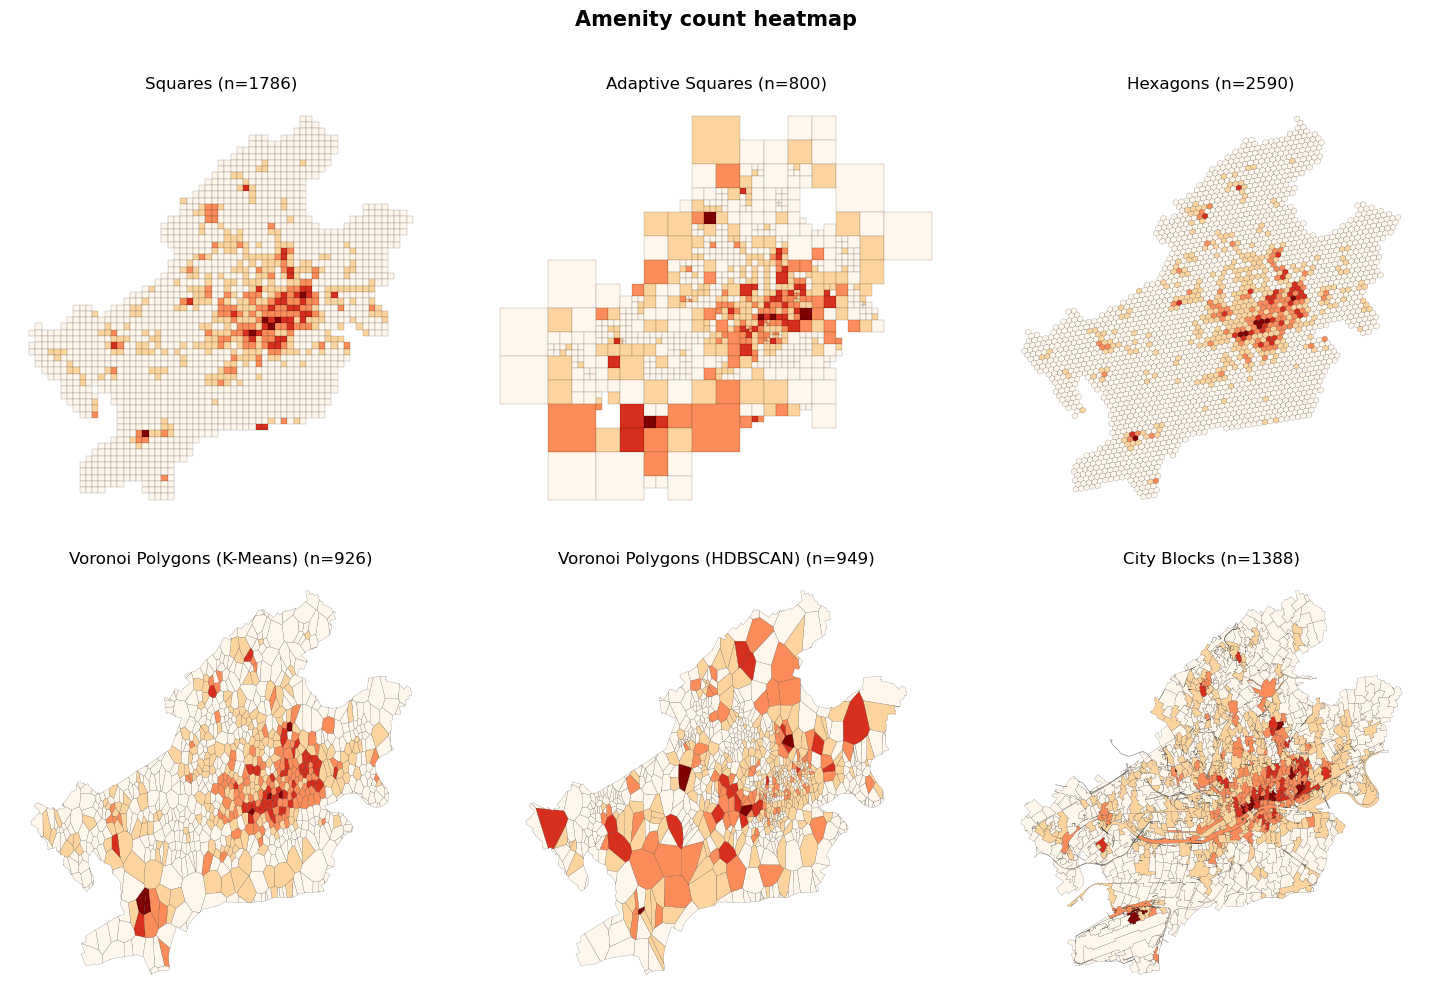

In [19]:
count_amenity_dfs = [
    count_amenity_qk,
    count_amenity_adaptive_qk,
    count_amenity_hexagon,
    count_amenity_voronoi_kmeans,
    count_amenity_voronoi_hdbscan,
    count_amenity_cityblocks,
]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for ax, df, title in zip(axs.flatten(), count_amenity_dfs, titles):
    ax.set_axis_off()
    df.plot(
        ax=ax,
        column="index_right",
        lw=0.1,
        alpha=1,
        scheme="fisherjenks",
        legend=False,
        cmap="OrRd",
        edgecolor="k",
    )
    ax.set_title(f"\n{title} (n={df.shape[0]})")

plt.suptitle("Amenity count heatmap", fontweight="bold", y=1, fontsize=15)
plt.tight_layout()
plt.show()

It can be seen that the most amenities are within the city center. There are many amenities near the Frankfurt airport (Southwest of Frankfurt) and also in the districts' local centers.

## Spatial Autocorrelation: Moran's I

At first sight, there seems to be an autocorrelation between polygons for amenities. In order to investigate the spatial autocorrelation, we can calculate Moran's I index.

In [20]:
mi_values = []
for count_df in count_amenity_dfs:
    wq = lp.weights.Queen.from_dataframe(count_df)
    wq.transform = "r"
    mi = esda.moran.Moran(count_df["index_right"], wq)
    mi_values.append(mi.I)

moran_df = pd.DataFrame(dict(zip(titles, [[i] for i in mi_values])))

('WARNING: ', 843, ' is an island (no neighbors)')
('WARNING: ', 899, ' is an island (no neighbors)')
('WARNING: ', 1135, ' is an island (no neighbors)')


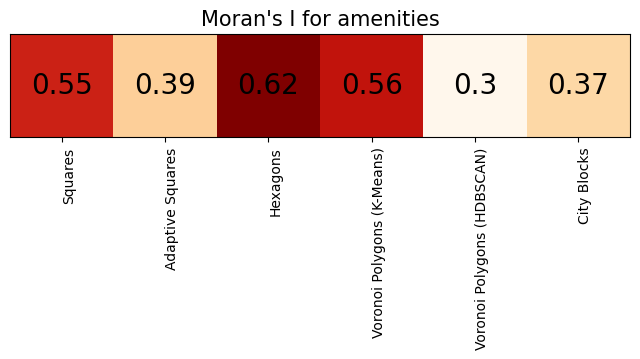

In [21]:
fig, ax = plt.subplots()
ax.imshow(moran_df, cmap="OrRd", interpolation="nearest")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
plt.tick_params(axis="y", left=False, labelleft=False)
ax.set_title("Moran's I for amenities", fontsize=15)
ax.set_xticks([])
ax.set_xticks(np.arange(len(titles)), labels=titles)
for j in range(len(titles)):
    text = ax.text(
        j, 0, round(mi_values[j], 2), ha="center", va="center", color="k", fontsize=20
    )

## Spatial Lag

Furthermore, we can calculate spatial lags and visualize them on the map.

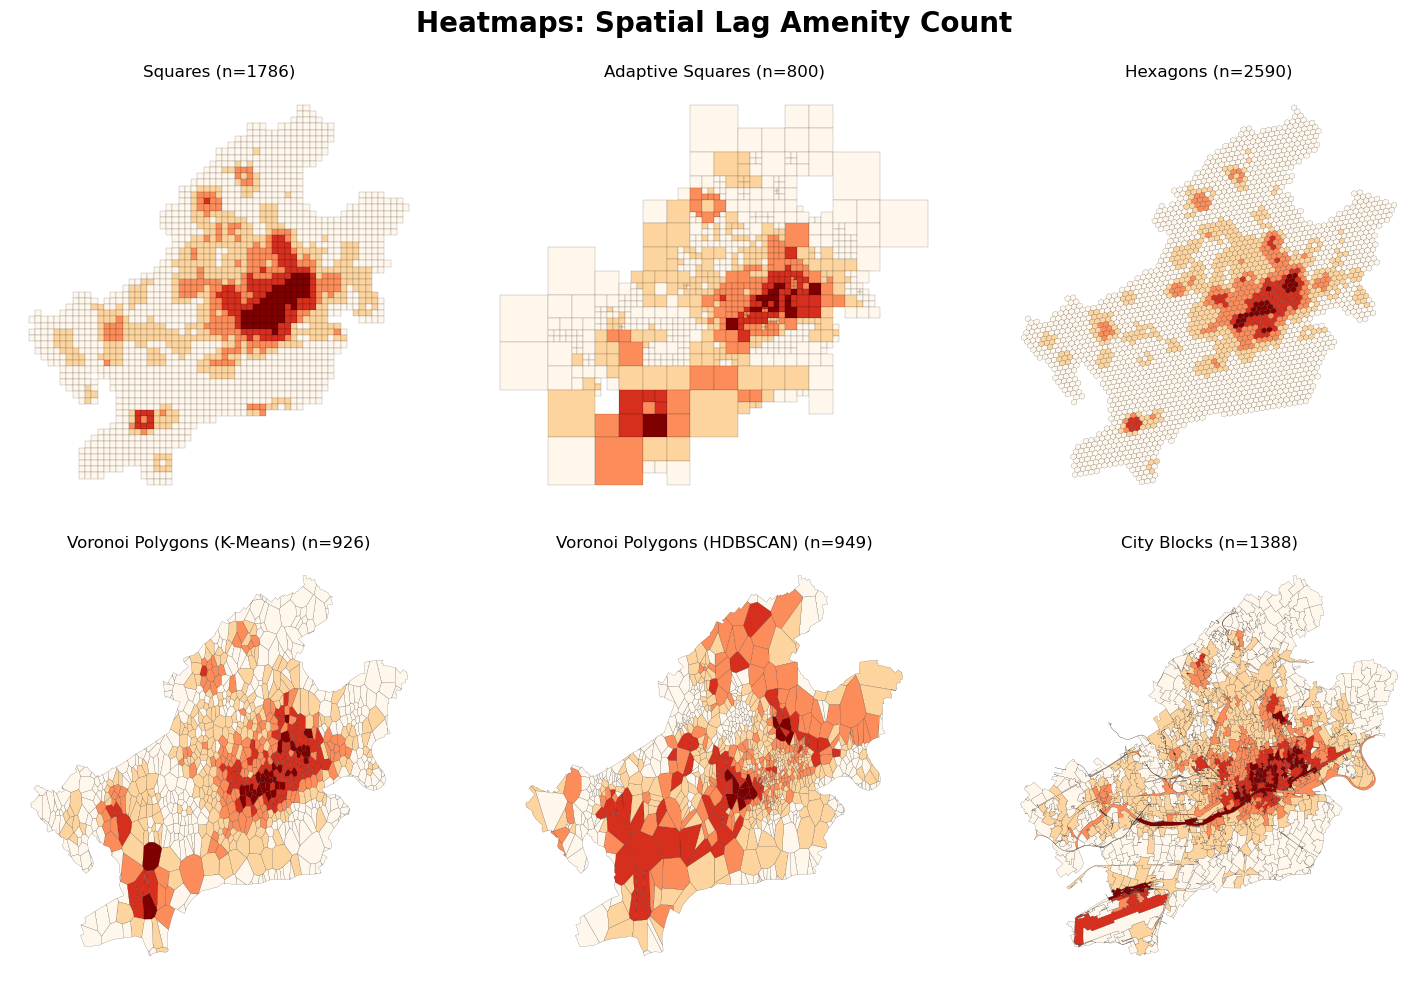

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for ax, count_df, title in zip(axs.flatten(), count_amenity_dfs, titles):
    wq = lp.weights.Queen.from_dataframe(count_df)
    y = count_df["index_right"]
    ylag = lp.weights.lag_spatial(wq, y)
    count_df.assign(ylag=ylag).plot(
        ax=ax,
        column="ylag",
        lw=0.1,
        alpha=1,
        scheme="fisherjenks",
        legend=False,
        cmap="OrRd",
        edgecolor="k",
    )
    ax.set_axis_off()
    ax.set_title(f"\n{title} (n={count_df.shape[0]})")

plt.suptitle("Heatmaps: Spatial Lag Amenity Count", fontweight="bold", fontsize=20)
plt.tight_layout()
plt.show()

Let's take a closer look at hexagons:

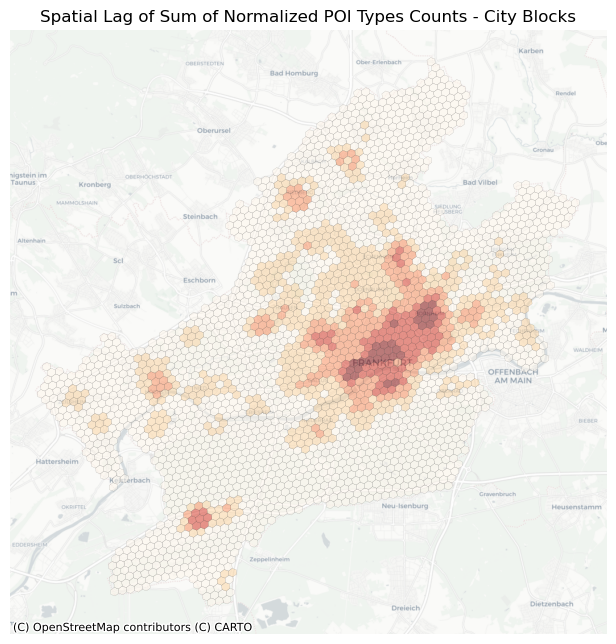

In [23]:
f, ax = plt.subplots()

wq = lp.weights.Queen.from_dataframe(count_amenity_hexagon)
y = count_amenity_hexagon["index_right"]
ylag = lp.weights.lag_spatial(wq, y)
count_amenity_hexagon.to_crs("EPSG:3857").assign(ylag=ylag).plot(
    ax=ax,
    column="ylag",
    lw=0.1,
    alpha=0.5,
    scheme="fisherjenks",
    legend=False,
    cmap="OrRd",
    edgecolor="k",
)
ax.set_axis_off()
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.title("Spatial Lag of Sum of Normalized POI Types Counts - City Blocks")
plt.show()